In [28]:
from __future__ import print_function
import pandas as pd
import numpy as np
import os
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import ipysheet
import colorsys
import xlsxwriter
import csv
from tqdm import tqdm_notebook as tqdm
from datetime import datetime
import matplotlib.pyplot as plt
import sys
import itertools
import time
from scipy import signal

In [8]:
# import python CWL files

module_path = os.path.abspath(os.path.join('/SSB'))
if module_path not in sys.path:
    sys.path.append(module_path)

from od_matrices import run, collect_groups, to_groups, plot_od_pixmap, compute_matrix_norms,collect_matrix_entries, generate_hist_plot, generate_bar_plot

module_path = os.path.abspath(os.path.join('../../python/python_src_preprocessing/target_learning'))
if module_path not in sys.path:
    sys.path.append(module_path)

from preprocessing.preprocessing import add_pedestrian_to_field, gaussian_pdf
import plotting.densitymap as densitymap 


# To-Do's

- ~~generate new mapping file~~
- load all pedestrian data (with new mapping)
- divide into 10 second groups
- sort out groups with ped count < 50
- add time sequences option for denstiy maps
- Generate density maps 


## Generate new mapping 

New mapping will move all combinations to -1,-1 which have a smaller pedestrian count than 0.001% of the total day. Combinations to be removed are in the file removed_mappings.csv

In [27]:
ped_radius = (0.195*1000)/500
signma = (0.7*1000)/500

def gauss_filter():
    x_range = np.linspace(-ped_radius,ped_radius,39)
    xx, yy = np.meshgrid(x_range,x_range, sparse=False)
    grid = np.sqrt(np.square(xx) + np.square(yy))
    gauss = np.vectorize(gaussian_pdf)
    gauss_grid = gauss(signma, grid, ped_radius_cm)
    
    return gauss_grid


def mapp_ped_positions(position_matrix, x,y):
    lowerLeftX = int((x[j]-1)/res)
    lowerLeftY = int((y[j]-1)/res)
    cordX = x[j]/res
    cordY = y[j]/res
    
    dx = abs(cordX - lowerLeftX)
    dy = abs(cordY - lowerLeftY)
    
    w1 = dx*dy
    w2 = dx*(1-dy)
    w3 = (1-dx)*dy
    w4 = (1-dx)*(1-dy)
    
    if abs(w1+w2+w3+w4 - 1) < 0.00001:
        print("error")
    
    position_matrix[lowerLeftY-1,lowerLeftX-1] = w1
    position_matrix[lowerLeftY, lowerLeftX-1] = w2
    position_matrix[lowerLeftY-1, lowerLeftX] = w3
    position_matrix[lowerLeftY, lowerLeftX] = w4
    
    return position_matrix

In [3]:
day = "20190905"
base = '/media/veracrypt1/objectstream_{0}/'.format(day)
# 6 7 8 9 10 11 12 13 14 15 16 17 18 19
new_dir = "csv{0}".format(day)
if new_dir not in os.listdir(): 
    os.makedirs(new_dir)
    
    
mapping = pd.read_csv(os.path.join(base, 'mapping_removed.csv'), dtype={'pedestrianId': 'str'})

# concaternate all selected hours of one day
od_complete_day = []
com_size = 0
hours = list(range(5,6))

In [36]:
scaling = 40
number_of_groups_used = 0

full = 0
missing = 0
pedestian_count = []

test = True

# generate filter once and convert to fft

gfilter = gauss_filter()

for h in hours:
    tick0 = time.time()
    frame = pd.read_csv(os.path.join(base, 'hours', 'hour-{0}.csv'.format(h)), dtype={'pedestrianId': 'str'})
    frame.x = frame.x.add(47000)
    #frame.x = frame.x.div(scaling)
    #frame.x = frame.x.round(0)
    frame.y = frame.y.add(10000)
    #frame.y = frame.y.div(scaling)
    #frame.y = frame.y.round(0)
    maxx = frame.x.max()
    minx = frame.x.min()
    maxy = frame.y.max()
    miny = frame.y.min()
    print(minx,maxx,miny,maxy)
    print(frame.head())
    
    od_complete_day.append(frame)
    com_size += frame.size
    # (freq, interval, skip_groups, off_set)
    parameters = ('S', 10, 1, 0)
    # divide pedestrians into 10s intervals, generate od-matrix
    groups, od_matrices, origins_str, destinations_str = collect_groups(frame, mapping, parameters, write2csv=False, prefix='{0}d-{1}h'.format(day,h))
    tick1 = time.time()
    print("Step 1 : ", tick1-tick0)
    tick0 = time.time()
    
    for group in groups: # 10 second intervals
        ped_count = len(group.pedestrianId.unique())
        pedestian_count.append(ped_count)
        
        number_of_groups_used+=1
        start_g = group.datetime.iloc[0]
        end_g = group.datetime.iloc[-1]
        sub_groups = to_groups(group, 1, 'S', 1, 0)
        
        info = []
        for sub_group in sub_groups: # 1 second intervals in 10 second intervals
            try:
                start_sg = sub_group.datetime.iloc[0]
                end_sg = sub_group.datetime.iloc[-1]
                info.append('{:%d, %b %Y}_{:%I:%M:%S %p}'.format(start_sg,start_sg))

                x_cords = sub_group['x'].values.tolist()
                y_cords = sub_group['y'].values.tolist()
                
                #position_matrix = 
                # convert to density maps
                #signal.convolve2d()
                
                test = sub_group['pedestrianId'].duplicated().any()
                if test:
                    print("has duplicates", boolean)
                    print(sub_group.head(20))

            except IndexError:
                info.append('-1')
        
        if '-1' in info or ped_count < 100:
            missing+=1
        else:
            full += 1
      
    tick1 = time.time()
    print("Step 2 :",tick1-tick0)
    print(full, missing)
    
plt.plot(list(range(0,360)),pedestian_count)
plt.show()
    # sort every group by pedestrian id, add every pedestrian within one group to the density field
    #add_pedestrian_to_field(ped, matrix, area, dimension, resolution, gauss_density_bound, sigma, ped_radius, general_density_matrix):
    


853.0999999999985 53745.59 375.97999999999956 18831.75
       timestamp pedestrianId        x         y
0  1567659600031     12243949  10815.8  16200.46
1  1567659600031     12244407  13734.4  16527.29
2  1567659600031     12245649  17402.9   6939.13
3  1567659600031     12245926  20771.8  15504.83
4  1567659600031     12246554  31930.4   3069.66


KeyboardInterrupt: 

In [ ]:
# check that correct combinations where removed
#plt.rcParams['figure.figsize'] = [7, 7]
#plot_od_pixmap(od_matrix[0][2].astype(int), fig_title="Complete OD-Matrix {0} day".format(day), val_precision=0)

In [ ]:
# ped, matrix, area, dimension, resolution, gauss_density_bound, sigma, ped_radius, general_density_matrix)
    

[[0.26576338 0.35954179 0.4055618  0.35954179 0.26576338]
 [0.35954179 0.54683324 0.67551634 0.54683324 0.35954179]
 [0.4055618  0.67551634 1.12516101 0.67551634 0.4055618 ]
 [0.35954179 0.54683324 0.67551634 0.54683324 0.35954179]
 [0.26576338 0.35954179 0.4055618  0.35954179 0.26576338]]


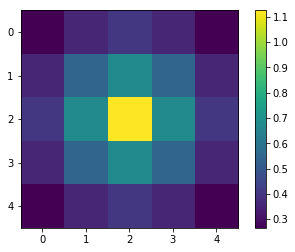

In [56]:
# convert radius and signma to cm
radius = 1
ped_radius = 1
signma = 0.7

def gaussian_pdf(sigma, x, radius):
    zaehler = ((radius*2)**2) * np.sqrt(3)  # S_p
    nenner = 2 * 2 * np.pi * (sigma**2)

    normalization_factor = zaehler/nenner
    individual_density = normalization_factor * \
        np.exp(-x / (2 * np.square(sigma)))

    return individual_density



gsfilter = gauss_filter()
plt.imshow(gsfilter)
plt.colorbar()
plt.show()

    

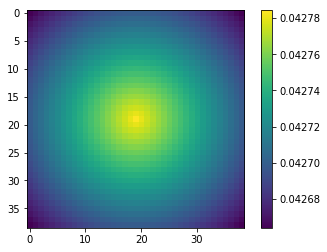